In [9]:
#!huggingface-cli login
#huggingface-cli login --token YOUR_TOKEN_GOES_HERE

# run from bash

In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.0+cu126
12.6
True


In [2]:
import os
os.environ["TRANSFORMERS_CACHE"] = "D:/Students/henrysun/huggingface"
os.environ["HF_HOME"] = "D:/Students/henrysun/huggingface"
print(os.environ.get("HF_HOME"))

D:/Students/henrysun/huggingface


## Testing w/ dreambooth for batch generation


In [3]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# run this first

e:\MaxSmartWhales\Software\envs\WhaleImageGen\Lib\site-packages\transformers\utils\hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
# pipe = DiffusionPipeline.from_pretrained("henrysun9074/dreambooth-out", torch_dtype=torch.bfloat16).to("cuda")
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_attention_slicing()   

# prompt = "a drone image of a humpback whale"
# image = pipe(prompt).images[0]
# image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

e:\MaxSmartWhales\Software\envs\WhaleImageGen\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diff

  0%|          | 0/50 [00:00<?, ?it/s]

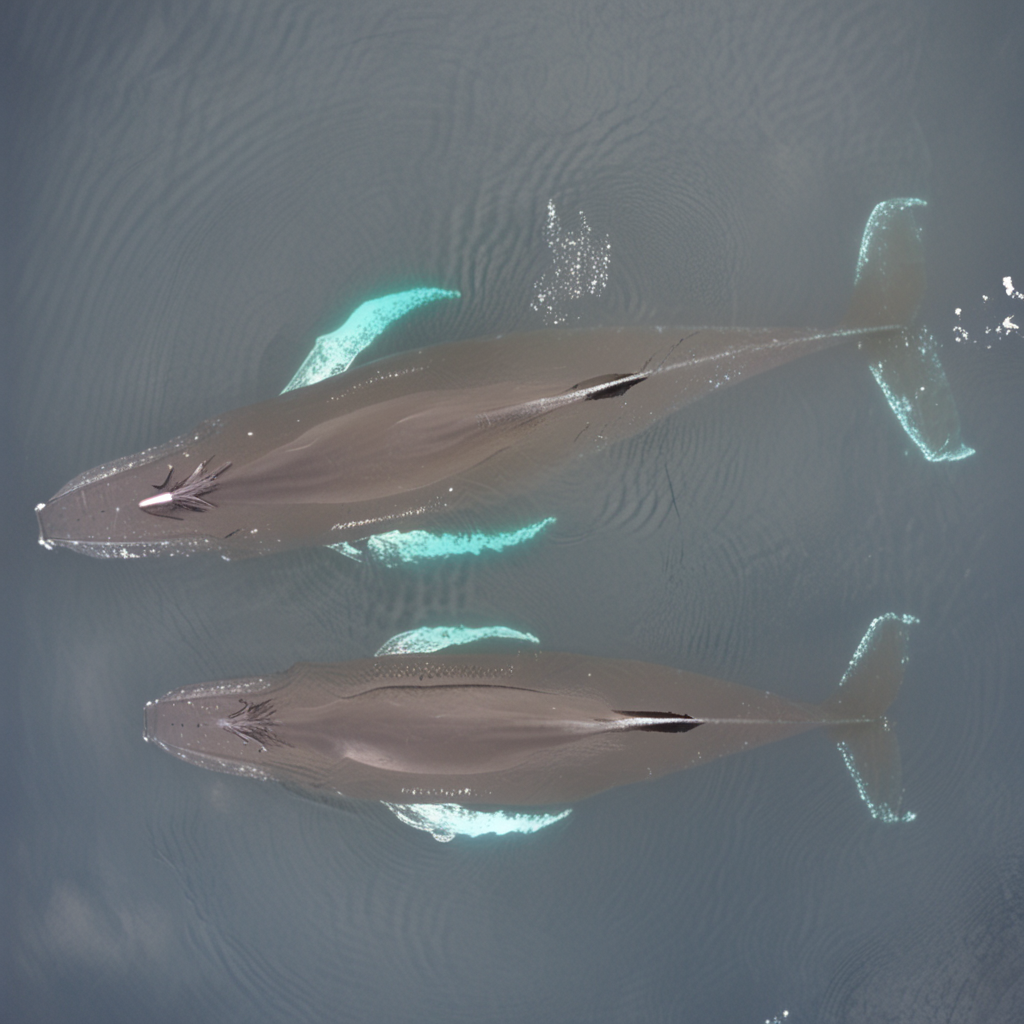

In [4]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize pipeline
# pipe_id = "stable-diffusion-v1-5/stable-diffusion-v1-5" # need SDXL 1.0?
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.bfloat16, cache_dir = r"E:\MaxSmartWhales\HuggingFaceModelCheckpoints").to("cuda")
pipe.load_lora_weights("henrysun9074/drone-humpback-whale-lora-1", weight_name="drone-humpback-whale-lora-1.safetensors", adapter_name="humpback")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

prompt = "A drone photo of a humpback whale swimming in the ocean"
image = pipe(prompt).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

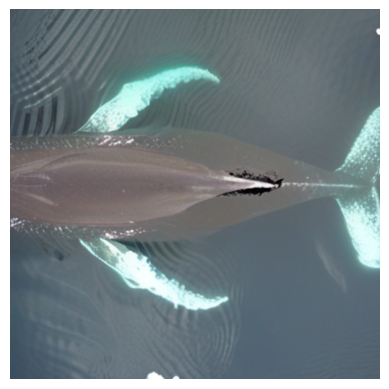

In [5]:
import random

def get_inputs(batch_size, seed_offset):
    generator = [torch.Generator("cuda").manual_seed(seed_offset + i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20
    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

# Generate images in multiple batches
def generate_images(pipe, total_images, batch_size):
    all_images = []
    seed_offset = random.randint(0, 1_000_000)  # For unique seeds across batches

    for _ in range(total_images // batch_size):
        inputs = get_inputs(batch_size, seed_offset)
        images = pipe(**inputs, height = 512, width = 512).images #3648
        all_images.extend(images)

        # Free GPU memory
        torch.cuda.empty_cache()

        seed_offset += batch_size

    return all_images

total_images = 1
batch_size = 1
images = generate_images(pipe, total_images, batch_size)

def make_image_grid(images, rows, cols):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np

    grid = Image.new("RGB", (cols * images[0].width, rows * images[0].height))
    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * img.width, i // cols * img.height))
    plt.imshow(np.asarray(grid))
    plt.axis("off")
    plt.show()

dim = int(total_images/batch_size)
make_image_grid(images, dim, batch_size)  # Adjust scale_factor as needed

In [7]:
import os
from PIL import Image
import zipfile
import shutil

# Create a folder to store images
output_folder = "E:\MaxSmartWhales\Images"
os.makedirs(output_folder, exist_ok=True)

# Save images
for idx, img in enumerate(images):
    img_path = os.path.join(output_folder, f"image_{idx + 1}.png")
    img.save(img_path)

# Compress images into a zip file
zip_path = f"{output_folder}.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print(f"Images saved and compressed into {zip_path}")

# Clean up: Uncomment to delete the generated image folder after compression
shutil.rmtree(output_folder)

Images saved and compressed into E:\MaxSmartWhales\Images.zip
